In [39]:
import csv
import math
import os
import cv2

from PIL import Image, ImageDraw, ImageEnhance
import numpy as np
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, DepthwiseConv2D, ZeroPadding2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from keras import backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

DATA_DIR = "images"

# 0.35, 0.5, 0.75, 1.0, 1.3, 1.4
ALPHA = 0.75

# 96, 128, 160, 192, 224
IMAGE_SIZE = 224

EPOCHS = 500
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 20

data = pd.read_csv('training.csv')
train, test = train_test_split(data, test_size=0.01, random_state=321)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

train.to_csv('train.csv', index=False)
test.to_csv('validation.csv', index=False)

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"
TRAINING_CSV = "training.csv"

In [2]:
df = pd.read_csv('validation.csv')

In [3]:
df.head()

,image_name,x1,x2,y1,y2
0,JPEG_20160624_135055_1000527160000.png,132,606,165,325
1,147771890839520161028_141911.png,123,544,52,452
2,1474715198275DSC07675.png,311,458,32,459
3,JPEG_20161117_112207_1000880661419.png,13,640,5,459
4,147444941744811473248953580-Roadster-Men-Navy-...,34,603,16,471


In [4]:

class DataGenerator(Sequence):

    def __init__(self, csv_file,rnd_rescale=True, rnd_multiply=True, rnd_color=True, rnd_crop=True, rnd_flip=False,
                 batch_size = BATCH_SIZE):
        self.paths = []
        self.coords = []
        self.batch_size = batch_size
        self.rnd_rescale = rnd_rescale
        self.rnd_multiply = rnd_multiply
        self.rnd_color = rnd_color
        self.rnd_crop = rnd_crop
        self.rnd_flip = rnd_flip

        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file)-1, 4))
            
        df = pd.read_csv(csv_file)

        for index, row in df.iterrows():
            path = os.path.join(DATA_DIR, row['image_name'])
            x1 = row['x1']
            x2 = row['x2']
            y1 = row['y1']
            y2 = row['y2']

            img = Image.open(path)
            width, height = img.size

            self.coords[index, 0] = x1
            self.coords[index, 1] = y1
            self.coords[index, 2] = x2 
            self.coords[index, 3] = y2 

            self.paths.append(path)
        
#         print(len(self.paths))
#         print(len(self.coords))


    def __len__(self):
        return math.ceil(len(self.coords) / self.batch_size)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_coords = self.coords[idx * self.batch_size:(idx + 1) * self.batch_size].copy()

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            x0,y0,x1,y1 = batch_coords[i]
            if self.rnd_rescale:
                old_width = img.width
                old_height = img.height

                rescale = np.random.uniform(low=0.6, high=1.4)
                new_width = int(old_width * rescale)
                new_height = int(old_height * rescale)

                img = img.resize((new_width, new_height))

                x0 *= new_width / old_width
                y0 *= new_height / old_height
                x1 *= new_width / old_width
                y1 *= new_height / old_height

            if self.rnd_crop:
                start_x = np.random.randint(0, high=np.floor(0.15 * img.width))
                stop_x = img.width - np.random.randint(0, high=np.floor(0.15 * img.width))
                start_y = np.random.randint(0, high=np.floor(0.15 * img.height))
                stop_y = img.height - np.random.randint(0, high=np.floor(0.15 * img.height))

                img = img.crop((start_x, start_y, stop_x, stop_y))

                x0 = max(x0 - start_x, 0)
                y0 = max(y0 - start_y, 0)
                x1 = min(x1 - start_x, img.width)
                y1 = min(y1 - start_y, img.height)

                if np.abs(x1 - x0) < 5 or np.abs(y1 - y0) < 5:
                    print("\nWarning: cropped too much (obj width {}, obj height {}, img width {}, img height {})\n".format(x1 - x0, y1 - y0, img.width, img.height))

            if self.rnd_flip:
                elem = np.random.choice([0, 90, 180, 270, 1423, 1234])
                if elem % 10 == 0:
                    x = x0 - img.width / 2
                    y = y0 - img.height / 2

                    x0 = img.width / 2 + x * np.cos(np.deg2rad(elem)) - y * np.sin(np.deg2rad(elem))
                    y0 = img.height / 2 + x * np.sin(np.deg2rad(elem)) + y * np.cos(np.deg2rad(elem))

                    x = x1 - img.width / 2
                    y = y1 - img.height / 2

                    x1 = img.width / 2 + x * np.cos(np.deg2rad(elem)) - y * np.sin(np.deg2rad(elem))
                    y1 = img.height / 2 + x * np.sin(np.deg2rad(elem)) + y * np.cos(np.deg2rad(elem))

                    img = img.rotate(-elem)
                else:
                    if elem == 1423:
                        img = img.transpose(Image.FLIP_TOP_BOTTOM)
                        y0 = img.height - y0
                        y1 = img.height - y1

                    elif elem == 1234:
                        img = img.transpose(Image.FLIP_LEFT_RIGHT)
                        x0 = img.width - x0
                        x1 = img.width - x1

            image_width = img.width
            image_height = img.height

            tmp = x0
            x0 = min(x0, x1)
            x1 = max(tmp, x1)

            tmp = y0
            y0 = min(y0, y1)
            y1 = max(tmp, y1)

            x0 = max(x0, 0)
            y0 = max(y0, 0)

            y0 = min(y0, image_height)
            x0 = min(x0, image_width)
            y1 = min(y1, image_height)
            x1 = min(x1, image_width)

            if self.rnd_color:
                enhancer = ImageEnhance.Color(img)
                img = enhancer.enhance(np.random.uniform(low=0.5, high=1.5))

                enhancer2 = ImageEnhance.Brightness(img)
                img = enhancer.enhance(np.random.uniform(low=0.7, high=1.3))

            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')
            pil_img = img
            img = np.array(img, dtype=np.float32)
            pil_img.close()
            if self.rnd_multiply:
                img[...,0] = np.floor(np.clip(img[...,0] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))
                img[...,1] = np.floor(np.clip(img[...,1] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))
                img[...,2] = np.floor(np.clip(img[...,2] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))

            batch_images[i] = preprocess_input(img.copy())
            
            batch_coords[i, 0] = x0 * IMAGE_SIZE / image_width
            batch_coords[i, 1] = y0 * IMAGE_SIZE / image_height
            batch_coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width
            batch_coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height 

        return batch_images, batch_coords

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        mse = 0
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i]
            pred = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]

            pred = np.maximum(pred, 0)

            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)

        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse

        print(" - val_iou: {} - val_mse: {}".format(iou, mse))

def create_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights=None)

    # to freeze layers
    for layer in model.layers:
        layer.trainable = True

    x = model.layers[-1].output
    x = Conv2D(256, kernel_size=3, name="coords1", activation='relu')(x)
    x = Conv2D(4, kernel_size=5, name="coords2", activation='relu')(x)
    x = Reshape((4,))(x)

    return Model(inputs=model.input, outputs=x)



In [19]:
def IOU(y_true, y_pred):
    diff_width = K.minimum(y_true[:,0] + y_true[:,2], y_pred[:,0] + y_pred[:,2]) - K.maximum(y_true[:,0], y_pred[:,0])
    diff_height = K.minimum(y_true[:,1] + y_true[:,3], y_pred[:,1] + y_pred[:,3]) - K.maximum(y_true[:,1], y_pred[:,1])
    intersection = K.maximum(diff_width, 0) * K.maximum(diff_height, 0)

    area_gt = y_true[:,2] * y_true[:,3]
    area_pred = y_pred[:,2] * y_pred[:,3]
    union = K.maximum(area_gt + area_pred - intersection, 0)

    #ntersection = K.sum(intersection * (union > 0))
    intersection = K.tf.where(union > 0, intersection, K.zeros_like(intersection))
    intersection = K.sum(intersection)
    union = K.sum(union)
    iou = (intersection / (union + epsilon()))
    return iou

def IOU_loss(y_true, y_pred):
    return -IOU(y_true, y_pred)

In [5]:
train_datagen = DataGenerator(TRAIN_CSV,rnd_crop= True)

In [6]:
imgs, coords = (train_datagen).__getitem__(10)

In [7]:
coords[2]

array([111.55938511,  27.27964206,  67.49110032, 194.57494407])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


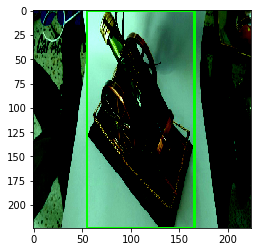

In [8]:
img = imgs[1]
x0,y0,x1,y1 = coords[1]
x1 = x0 + x1
y1 = y0 + y1
cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)),(0, 255, 0), 2)
plt.imshow(img)

In [9]:
x1

165.45051369863012

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


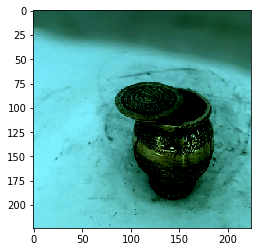

In [10]:
plt.imshow(imgs[0])

In [40]:
# model = create_model()
# model.summary()

train_datagen = DataGenerator(TRAIN_CSV)
validation_datagen = Validation(generator=DataGenerator(VALIDATION_CSV,  rnd_rescale=False, rnd_multiply=False,
                                                        rnd_crop=False, rnd_flip=False,batch_size = 256))

model.compile(loss="mean_absolute_error", optimizer="adam", metrics=['accuracy', IOU])

checkpoint = ModelCheckpoint("mobilenetv2-no_weights-data_aug-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

# model.summary()



In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 24) 648         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 24) 96          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [ ]:
model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[validation_datagen, reduce_lr, stop, checkpoint],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)


Epoch 1/500
237/434 [===============>..............] - ETA: 1:09 - loss: 2.8374 - acc: 0.9688 - IOU: 0.9444

293/434 [===================>..........] - ETA: 46s - loss: 2.8730 - acc: 0.9681 - IOU: 0.9437

433/434 [============================>.] - ETA: 0s - loss: 2.9447 - acc: 0.9664 - IOU: 0.9426 - val_iou: 0.9076000000000001 - val_mse: 1.5919

Epoch 00001: val_iou improved from -inf to 0.90760, saving model to mobilenetv2-no_weights-data_aug-0.91.h5
434/434 [==============================] - 146s 335ms/step - loss: 2.9458 - acc: 0.9664 - IOU: 0.9425
Epoch 2/500
 79/434 [====>.........................] - ETA: 1:23 - loss: 3.0857 - acc: 0.9660 - IOU: 0.9399

218/434 [==============>...............] - ETA: 54s - loss: 3.1493 - acc: 0.9655 - IOU: 0.9393

433/434 [============================>.] - ETA: 0s - loss: 3.0513 - acc: 0.9639 - IOU: 0.9409 - val_iou: 0.8873000000000001 - val_mse: 1.8557000000000001

Epoch 00002: val_iou did not improve from 0.90760
434/434 [=======================

434/434 [==============================] - 119s 274ms/step - loss: 2.3848 - acc: 0.9724 - IOU: 0.9535
Epoch 24/500
 17/434 [>.............................] - ETA: 1:15 - loss: 2.2960 - acc: 0.9743 - IOU: 0.9562

152/434 [=========>....................] - ETA: 1:09 - loss: 2.3849 - acc: 0.9696 - IOU: 0.9537

433/434 [============================>.] - ETA: 0s - loss: 2.3793 - acc: 0.9713 - IOU: 0.9535 - val_iou: 0.9249 - val_mse: 1.4291

Epoch 00024: val_iou improved from 0.92390 to 0.92490, saving model to mobilenetv2-no_weights-data_aug-0.92.h5
434/434 [==============================] - 119s 275ms/step - loss: 2.3782 - acc: 0.9712 - IOU: 0.9536
Epoch 25/500
182/434 [===========>..................] - ETA: 1:05 - loss: 2.3590 - acc: 0.9715 - IOU: 0.9541

226/434 [==============>...............] - ETA: 54s - loss: 2.3496 - acc: 0.9729 - IOU: 0.9543

433/434 [============================>.] - ETA: 0s - loss: 2.3754 - acc: 0.9729 - IOU: 0.9535 - val_iou: 0.9219 - val_mse: 1.5156

Epoch 0002

434/434 [==============================] - 123s 284ms/step - loss: 2.2938 - acc: 0.9707 - IOU: 0.9552
Epoch 36/500
399/434 [==========================>...] - ETA: 9s - loss: 2.2664 - acc: 0.9702 - IOU: 0.9555

425/434 [============================>.] - ETA: 2s - loss: 2.2694 - acc: 0.9703 - IOU: 0.9555

In [ ]:
sample = pd.read_csv("train.csv")
sample.head()

In [43]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

# from keras.applications.mobilenetv2 import preprocess_input

WEIGHTS_FILE = "mobilenetv2-no_weights-data_aug-0.93.h5"
IMAGES = "images/*png"

# model = create_model()
model.load_weights(WEIGHTS_FILE)


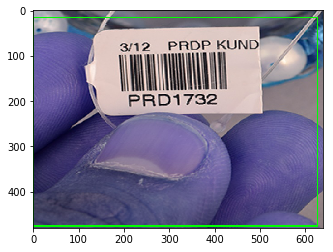

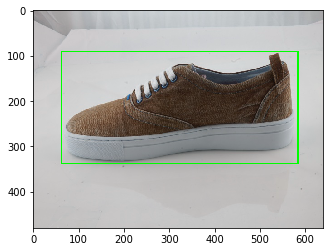

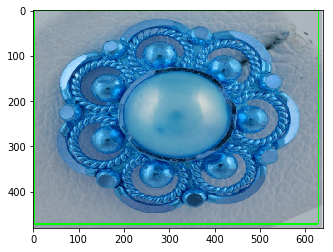

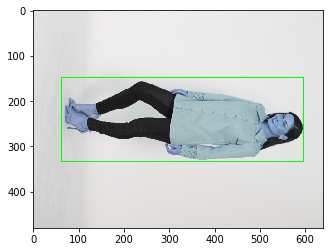

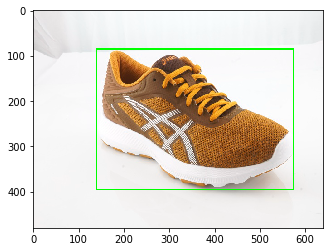

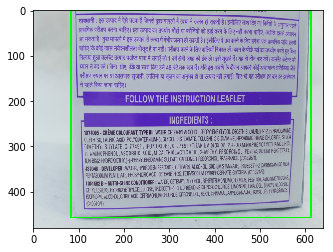

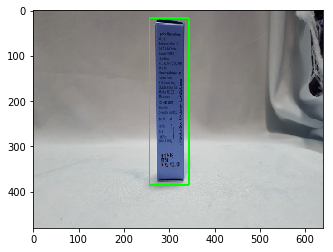

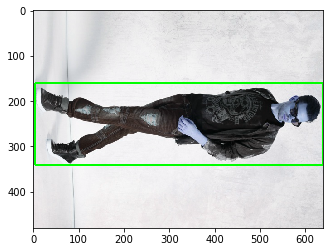

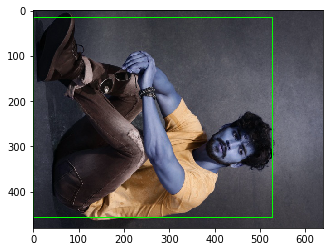

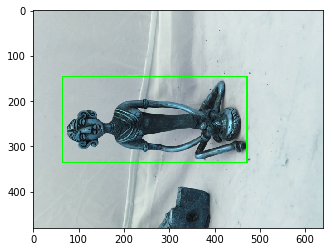

In [44]:

for filename in glob.glob(IMAGES)[8000:8010]:
    unscaled = cv2.imread(filename)
    image_height, image_width, _ = unscaled.shape

    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    region = model.predict(x=np.array([feat_scaled]))[0]

    x0 = int(region[0] * image_width / IMAGE_SIZE)
    y0 = int(region[1] * image_height / IMAGE_SIZE)

    x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

    cv2.rectangle(unscaled, (x0, y0), (x1, y1), (0, 255, 0), 2)
    plt.imshow(unscaled)
    plt.show()

In [45]:
sample = pd.read_csv("test.csv")
sample.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


In [46]:
for index, row in sample.iterrows():
    unscaled = cv2.imread('images/'+row['image_name'])
    image_height, image_width, _ = unscaled.shape

    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    region = model.predict(x=np.array([feat_scaled]))[0]

    x1 = int(region[0] * image_width / IMAGE_SIZE)
    y1 = int(region[1] * image_height / IMAGE_SIZE)

    x2 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y2 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

    sample.iloc[index,1] = x1
    sample.iloc[index,2] = x2
    sample.iloc[index,3] = y1
    sample.iloc[index,4] = y2

sample.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,233.0,445.0,85.0,405.0
1,1473231475010DeeplearnS11276.png,76.0,566.0,138.0,352.0
2,JPEG_20161205_135307_1000155917326.png,143.0,492.0,53.0,436.0
3,JPEG_20160711_123440_1000518778437.png,211.0,466.0,86.0,416.0
4,JPEG_20160803_115329_100034020722.png,125.0,494.0,43.0,438.0


In [47]:
sample.to_csv('0.01-prediction.csv', index=False)